In [4]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/CW30154-hnrnpk")
results_dir.mkdir(parents=True, exist_ok=True)

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Load input RNA allelic counts.

In [22]:
basedir = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/allelic/"
input_files = [ basedir + "CW30154-hnrnpk-input_allelic.out" ]

input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files ]
input_counts[0].head()

IP_files = [ basedir + "CW30154-hnrnpk-ip_allelic.out" ]

IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files ]
IP_counts[0]

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,16071,rs541172944,G,A,80,0,80
1,chr1,16141,rs529651976,C,T,82,0,82
2,chr1,16280,.,T,C,63,0,63
3,chr1,137978,rs529853750,G,A,252,0,252
4,chr1,139029,rs531551691,C,T,299,0,299
...,...,...,...,...,...,...,...,...
1790782,chr22,50777260,rs551225150,C,T,18,0,18
1790783,chr22,50777292,.,A,G,14,0,14
1790784,chr22,50777325,rs549110447,T,C,12,0,12
1790785,chr22,50777331,rs567609012,C,G,12,0,12


Observed genotype data (after running StrandScript)

## Load imputed genotypes

In [5]:
sanger_feather = Path("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.feather")
sanger = pd.read_feather(sanger_feather)
del sanger["index"]

In [6]:
sanger = sanger[sanger.SNP != "."]
sanger = sanger[~sanger.SNP.duplicated()] # this removes triallelic SNPs, which I don't think we know how to handle anyway

cols = list(sanger.columns)
cols[0], cols[1] = cols[1], cols[0]
sanger = sanger.loc[:,cols]

## Look at phase within genes

In [7]:
sample_ind = [ g for g in cols if "CW30154" in g ][0]

In [9]:
import vcf
import gzip
vcf_reader = vcf.Reader(filename = '/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.vcf.gz')

#gen = [next(vcf_reader) for _ in range(10000)]
gen = vcf_reader

v = [ (record.CHROM, 
 record.POS, 
 record.ID, 
 record.REF, 
 record.ALT[0].sequence, 
 record.genotype(sample_ind).data.GT, 
 record.genotype(sample_ind).data.ADS[0],
 record.genotype(sample_ind).data.ADS[1]) 
      for record in gen if (record.genotype(sample_ind).data.GT != "0|0") ]

chroms, pos, ids, ref, alt, gt, ads1, ads2 = zip(*v)
phased = pd.DataFrame({
    "contig" : chroms,
    "position" : pos,
    "SNP" : ids, 
    "refAllele" : ref, 
    "altAllele" : alt, 
    "GT" : gt, 
    "dosage1" : ads1, # dosage for haplotype 1
    "dosage2" : ads2 # dosage for haplotype 2
})

phased.to_csv(
    '/gpfs/commons/home/daknowles/pooledRBPs/genotypes/CW30154.tsv.gz', 
    index = False, 
    sep = "\t")

In [15]:
phased

,contig,position,SNP,refAllele,altAllele,GT,dosage1,dosage2
0,10,69083,None,C,T,1|1,0.75,0.75
1,10,95353,None,G,A,1|1,0.75,0.75
2,10,101023,None,A,G,1|1,0.85,0.85
3,10,109082,None,T,C,1|1,0.85,0.85
4,10,117636,None,A,G,1|1,0.85,0.85
...,...,...,...,...,...,...,...,...
3062344,9,141076883,rs11791858,A,G,0|1,0.00,1.00
3062345,9,141077352,rs1902482,T,C,1|1,1.00,1.00
3062346,9,141078304,rs4102299,C,T,1|1,1.00,1.00
3062347,9,141087366,rs1820789,A,G,1|1,1.00,1.00


In [30]:
phased.SNP = phased.SNP.astype('str')
phased.contig = "chr" + phased.contig
phased_clean = phased[phased.SNP != "None"]

In [31]:
dat = input_counts[0]
dat_IP = IP_counts[0]

dat = dat[dat.variantID != "."]
dat = dat[~dat.variantID.duplicated()]
dat_IP = dat_IP[dat_IP.variantID != "."]
dat_IP = dat_IP[~dat_IP.variantID.duplicated()]

imp_merged = phased_clean.rename(
    columns = {"SNP" : "variantID"}
).merge(
    dat, 
    on = ["contig", "variantID", "refAllele", "altAllele"],
    suffixes = ["_hg19",""]) # sanger is hg19
imp_merged["input_ratio"] = imp_merged.altCount / imp_merged.totalCount


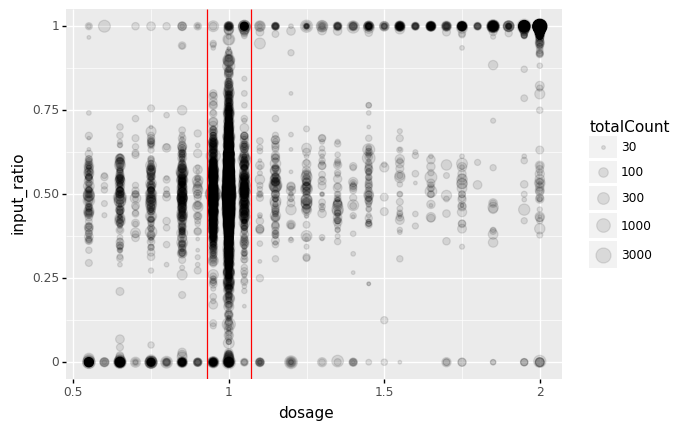

<ggplot: (8735400254049)>

In [62]:
imp_merged["dosage"] = imp_merged.dosage1 + imp_merged.dosage2

import plotnine as p9
( p9.ggplot(imp_merged[imp_merged.totalCount >= 30], p9.aes("dosage", "input_ratio", size = "totalCount")) + 
 p9.geom_point(alpha = 0.1) + 
 p9.scale_size(trans = "log10") + 
 p9.geom_vline(xintercept = [.93,1.07], color = "red") )

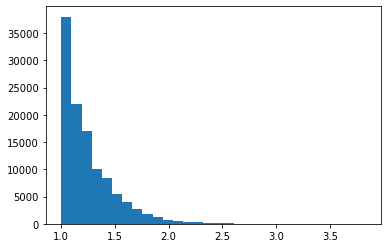

In [52]:
_ = plt.hist(np.log10(imp_merged.totalCount), 30) # when/where did this get filtered?! only includes totalCount >= 10

In [74]:
het = imp_merged[np.logical_and(imp_merged.dosage > 0.93, imp_merged.dosage < 1.07)].copy()
het["phased_ratio"] = np.where(het.GT == "0|1", het.input_ratio, 1. - het.input_ratio)
het

,contig,position_hg19,variantID,refAllele,altAllele,GT,dosage1,dosage2,position,refCount,altCount,totalCount,input_ratio,dosage,phased_ratio
51,chr10,853674,rs1555897,A,C,0|1,0.0,1.0,807734,3,8,11,0.727273,1.0,0.727273
53,chr10,856918,rs4229,A,T,0|1,0.0,1.0,810978,26,31,57,0.543860,1.0,0.543860
54,chr10,858022,rs9124,C,T,0|1,0.0,1.0,812082,13,19,32,0.593750,1.0,0.593750
55,chr10,858394,rs7703,C,T,0|1,0.0,1.0,812454,27,14,41,0.341463,1.0,0.341463
56,chr10,861390,rs12243303,C,T,0|1,0.0,1.0,815450,3,11,14,0.785714,1.0,0.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112931,chr9,140697937,rs72766962,C,T,1|0,1.0,0.0,137803485,9,13,22,0.590909,1.0,0.409091
112935,chr9,140709605,rs67116066,A,G,1|0,1.0,0.0,137815153,2,8,10,0.800000,1.0,0.200000
112936,chr9,140709647,rs72766964,A,G,1|0,1.0,0.0,137815195,4,12,16,0.750000,1.0,0.250000
112940,chr9,140955661,rs62580940,C,T,0|1,0.0,1.0,138061209,2,9,11,0.818182,1.0,0.818182


In [152]:
from sklearn.neighbors import NearestNeighbors

dists = []
rats = []

for chrom in range(1,23):
    print(chrom, end = "\r")
    chrdat = het[het.contig == ("chr%i" % chrom)]
    chrdat = chrdat[chrdat.totalCount >= 30]
    X = chrdat.position.to_numpy().reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=5).fit(X)
    distances, indices = nbrs.radius_neighbors(X, radius = 2000)
    phased_ratio = chrdat.phased_ratio.to_numpy()
    ratios = np.concatenate([ (phased_ratio[i] - phased_ratio[j]) for i,j in enumerate(indices) ])
    dist = np.concatenate(distances)
    to_keep = dist > 0
    dists.append( dist[to_keep] )
    rats.append( ratios[to_keep] )


In [160]:
p = het.phased_ratio[het.totalCount >= 30]
s = p.std()
np.sqrt(2.) * s

0.16839751547588763

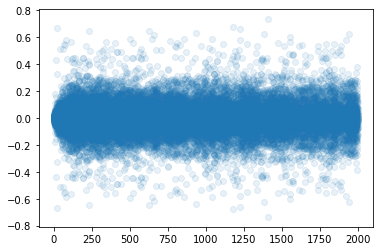

In [154]:
dist = np.concatenate(dists)
ratios = np.concatenate(rats)
plt.scatter(dist, ratios, alpha = 0.1)

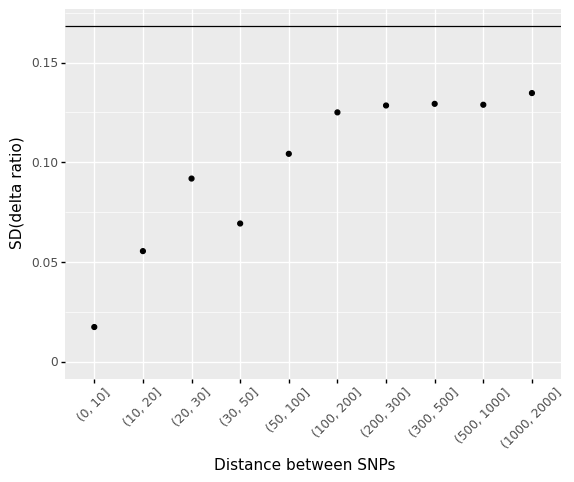

<ggplot: (8735802589284)>

In [162]:
delta = pd.DataFrame({ "dist" : dist, "delta_ratio" : ratios})
delta["dist_discrete"] = pd.cut(
    delta.dist,
    bins=[0, 10, 20, 30, 50, 100, 200, 300, 500, 1000, 2000])

summed = delta.groupby('dist_discrete', as_index=False).agg({'delta_ratio' : 'std'})

( p9.ggplot(summed, p9.aes("dist_discrete", 'delta_ratio')) + 
 p9.geom_point() + 
 p9.theme(axis_text_x = p9.element_text(angle = 45)) + 
 p9.ylab("SD(delta ratio)") + 
 p9.xlab("Distance between SNPs") + 
 p9.geom_hline(yintercept = np.sqrt(2.) * s) +
 p9.expand_limits(y = [0])
)

In [163]:
from pooledQTL import interval_utils

exons = pd.read_csv("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/gencode.v38.exons.txt.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
exons = exons[(exons.end - exons.start) >= 9] # remove super short exons
exons_tree = interval_utils.to_interval_trees(exons, chroms)

overlap["exonic"] = interval_utils.get_overlap(exons_tree, overlap)

genes = pd.read_csv("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/genes.tsv.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
genes = genes[genes.end - genes.start >= 100]
genes_tree = interval_utils.to_interval_trees(genes, chroms)

overlap["genic"] = interval_utils.get_overlap(genes_tree, overlap)


NameError: name 'interval_utils' is not defined

# Load IP count data and join with input and genotype

<AxesSubplot:>

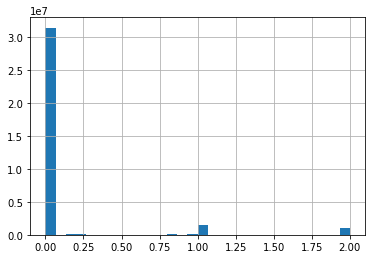

In [5]:
sanger[sample_ind].hist(bins=30)

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,16071,rs541172944,G,A,80,0,80
1,chr1,16141,rs529651976,C,T,82,0,82
2,chr1,16280,.,T,C,63,0,63
3,chr1,137978,rs529853750,G,A,252,0,252
4,chr1,139029,rs531551691,C,T,299,0,299
...,...,...,...,...,...,...,...,...
1790782,chr22,50777260,rs551225150,C,T,18,0,18
1790783,chr22,50777292,.,A,G,14,0,14
1790784,chr22,50777325,rs549110447,T,C,12,0,12
1790785,chr22,50777331,rs567609012,C,G,12,0,12


In [18]:
[ g.totalCount.sum()/1e6 for g in IP_counts ]

[47.223344]

In [19]:
[ g.totalCount.sum()/1e6 for g in input_counts ]

[47.338812]

In [10]:
sample_ind

'CW30154-1-1194512551_CW30154-1-1194512551'

In [15]:
import PyVCF

ModuleNotFoundError: No module named 'PyVCF'

Joining genotype and input allelic counts. 
Have to match on rsID because sanger.vcf is hg19 and allelic counts are on hg38


In [9]:
dat = input_counts[0]
dat_IP = IP_counts[0]

dat = dat[dat.variantID != "."]
dat = dat[~dat.variantID.duplicated()]
dat_IP = dat_IP[dat_IP.variantID != "."]
dat_IP = dat_IP[~dat_IP.variantID.duplicated()]

imp_merged = sanger.rename(
    columns = {"SNP" : "variantID"}
).merge(
    dat, 
    on = ["contig", "variantID", "refAllele", "altAllele"],
    suffixes = ["_hg19",""]) # sanger is hg19
# there are only 0.08% flipped alleles so not worth doing.
# np.isnan(imp_merged.iloc[:,5:16]).any() all False
imp_merged["input_ratio"] = imp_merged.altCount / imp_merged.totalCount


Joining genotype and input allelic counts


In [13]:
sanger

,contig,position,SNP,refAllele,altAllele,CW30274-1-1194512543_CW30274-1-1194512543,CW30454-1-1194512472_CW30454-1-1194512472,CW30421-1-1194512512_CW30421-1-1194512512,CW70372-1-1194512488_CW70372-1-1194512488,CW40201-1-1194512480_CW40201-1-1194512480,CW30525-1-1194512464_CW30525-1-1194512464,CW30190-1-1194512504_CW30190-1-1194512504,CW30108-1-1194512496_CW30108-1-1194512496,CW30154-1-1194512551_CW30154-1-1194512551,CW70179-1-1194512535_CW70179-1-1194512535,CW70142-1-1194512527_CW70142-1-1194512527
0,chr10,60494,rs568182971,A,G,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,chr10,60523,rs112920234,T,G,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,chr10,60803,rs536478188,T,G,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,chr10,61020,rs115033199,G,C,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,chr10,61314,rs569207726,T,C,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39131573,chr9,141111414,rs558431167,G,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39131574,chr9,141112371,rs563889179,G,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39131575,chr9,141127361,rs528107815,G,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39131576,chr9,141127558,rs553270612,G,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


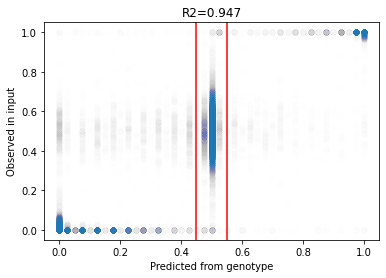

In [11]:
imp_merged["pred_ratio"] = 0.5 * imp_merged.loc[:,sample_ind].to_numpy()

imp_merged_30 = imp_merged[imp_merged.totalCount >= 30]
corr,_ = scipy.stats.pearsonr(imp_merged_30.pred_ratio, imp_merged_30.input_ratio)
R2 = corr*corr
plt.scatter(imp_merged_30.pred_ratio, imp_merged_30.input_ratio, alpha = 0.005) 
plt.title("R2=%.3f" % R2)
plt.xlabel("Predicted from genotype")
plt.ylabel("Observed in input")
plt.axvline(x = 0.45, color = 'r')
plt.axvline(x = 0.55, color = 'r')
plt.show()

Joining genotype+input with IP allelic counts

In [ ]:
merged = imp_merged.drop(
    labels=sanger.columns[range(5,16)], axis=1 # # .rename(columns={"position_y":"position"} # ,"contig_x":"contig" ?
).merge(
    dat_IP, 
    on = ("contig", "position", "variantID", "refAllele", "altAllele"), 
    suffixes = ("_input", "_IP"))
#merged = merged.drop(labels=["contig_y", "position_x" ], axis=1)

merged["IP_ratio"] = merged.altCount_IP / merged.totalCount_IP

input_total_min = 10
allele_count_min = 4 
ip_total_min = 30

# filter for reasonable counts
dat_sub = merged[merged.totalCount_input >= input_total_min]
dat_sub = dat_sub[dat_sub.refCount_input >= allele_count_min]
dat_sub = dat_sub[dat_sub.altCount_input >= allele_count_min]
dat_sub = dat_sub[dat_sub.totalCount_IP >= ip_total_min]
dat_sub = dat_sub[dat_sub.pred_ratio >= 0.45]
dat_sub = dat_sub[dat_sub.pred_ratio <= 0.55]

In [40]:
dat_subsub = dat_sub[dat_sub.pred_ratio == 0.5]

<AxesSubplot:>

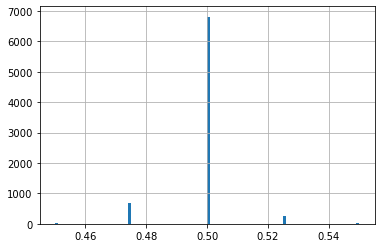

In [39]:
dat_sub.pred_ratio.hist(bins=100)

# Run beta models

Learned hyperparameters: {'input_conc': 65.43270111083984, 'input_count_conc': 127.34178161621094, 'IP_conc': 49.89799118041992, 'IP_count_conc': 212.3877716064453}


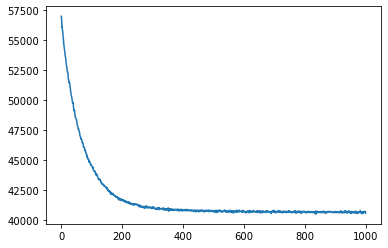

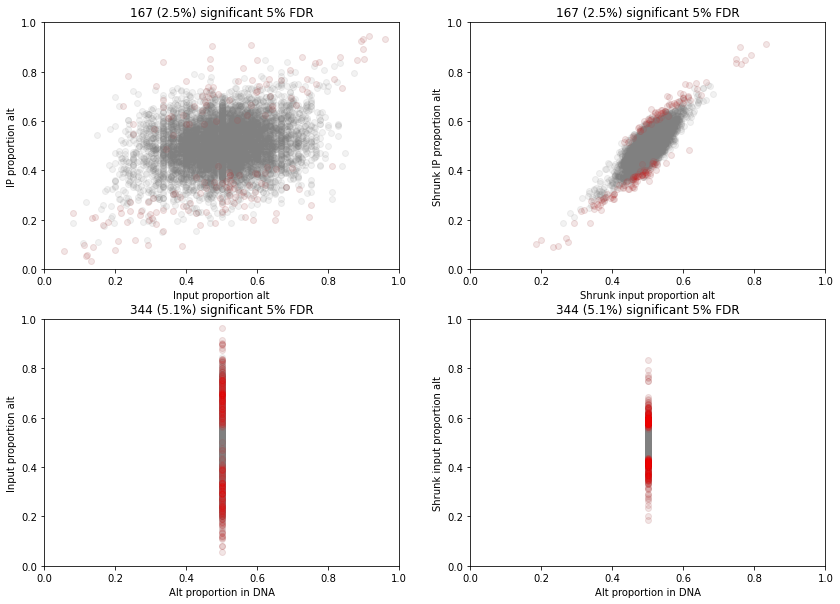

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input,altCount_input,totalCount_input,input_ratio,...,totalCount_IP,IP_ratio,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q
0,chr10,956400,rs7069505,C,T,910460,8,15,23,0.652174,...,49,0.571429,0.231224,0.231224,0.171103,0.088287,0.225528,-0.005697,0.222028,0.489765
1,chr10,970426,rs11253516,A,G,924486,22,20,42,0.476190,...,40,0.575000,0.011196,0.011196,0.157642,0.471690,0.128471,0.117275,0.216013,0.293597
2,chr10,1058196,rs17131848,C,T,1012256,7,5,12,0.416667,...,33,0.575758,0.092355,0.092355,0.207929,0.328462,0.091469,-0.000886,0.249267,0.498582
3,chr10,5490932,rs12570751,A,T,5448969,5,6,11,0.545455,...,38,0.421053,-0.041453,-0.041453,0.195225,0.415923,-0.081995,-0.040542,0.189202,0.415164
4,chr10,5491495,rs56676146,A,G,5449532,9,5,14,0.357143,...,62,0.467742,-0.159593,-0.159593,0.189450,0.199781,-0.143951,0.015642,0.235675,0.473540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6801,chr9,140481946,rs2297005,G,A,137587494,8,11,19,0.578947,...,69,0.463768,0.082906,0.082906,0.200758,0.339817,-0.066163,-0.149068,0.211744,0.240715
6802,chr9,140483339,rs2297004,G,A,137588887,5,7,12,0.583333,...,70,0.428571,-0.062381,-0.062381,0.176493,0.361876,-0.168157,-0.105775,0.213610,0.310237
6803,chr9,140512555,rs1045777,G,A,137618103,15,18,33,0.545455,...,41,0.536585,0.096870,0.096870,0.182586,0.297866,0.108962,0.012092,0.231030,0.479130
6804,chr9,140530935,rs2501566,A,G,137636483,16,14,30,0.466667,...,31,0.677419,0.062388,0.062388,0.195233,0.374652,0.225764,0.163376,0.178729,0.180332


In [45]:

results = beta_model.fit_and_save(dat_subsub, 
                                 results_dir / ("beta" 
                                                + ("_struct" if use_structured_guide else "") 
                                                + ".tsv.gz"),
                                 use_structured_guide = True,
                                 iterations = 1000,
                                 device = device)
results

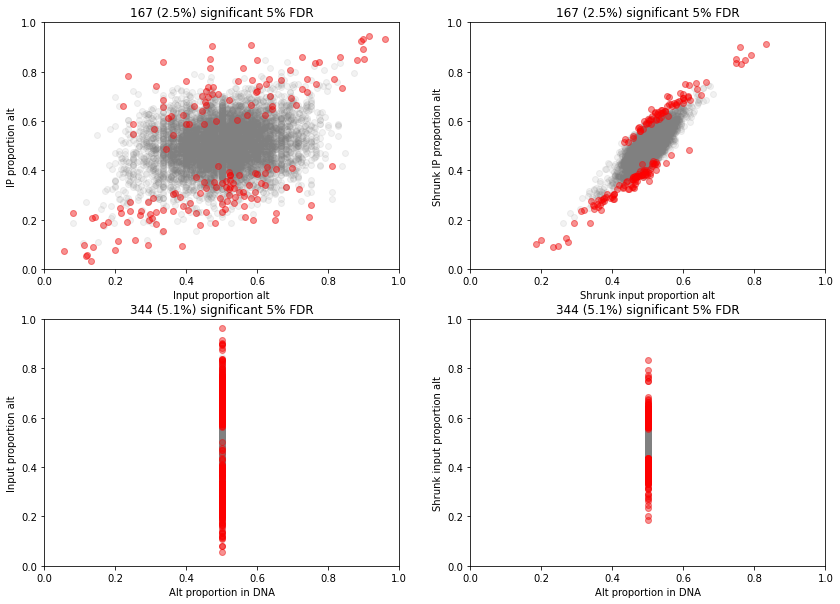

()

In [47]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold, sig_alpha=0.4)

For the beta model we model the two ratios (input and IP) separately but allow posterior dependence through the structured guide. For the Gaussian model we model the ASE effect (difference between DNA and RNA logit ratio) and ASB effect (difference between RNA and IP logit ratio). 

# Gaussian model without replicates

Could also run this with the mean field guide. 

Learned hyperparameters: {'ase_scale': 0.1695626825094223, 'input_count_conc': 139.3909454345703, 'asb_scale': 0.1954687535762787, 'IP_count_conc': 110.2754135131836, 'ase_t_df': 4.1406402587890625, 'asb_t_df': 7.984660625457764}


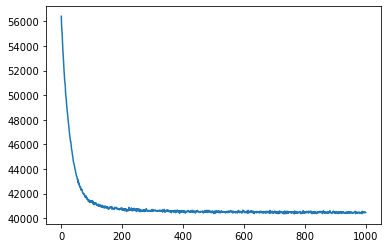

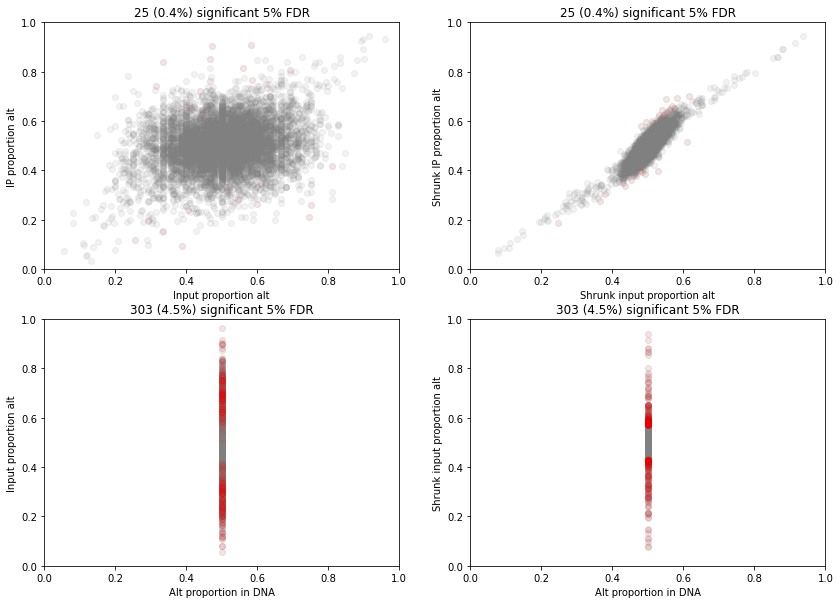

In [48]:
results = gaussian_model.fit_and_save(dat_subsub, 
                                         results_dir / ("normal" 
                                                        + ("_struct" if use_structured_guide else "") 
                                                        + ".tsv.gz"),
                                         use_structured_guide = True,
                                         iterations = 1000,
                                         device = "cuda:0")

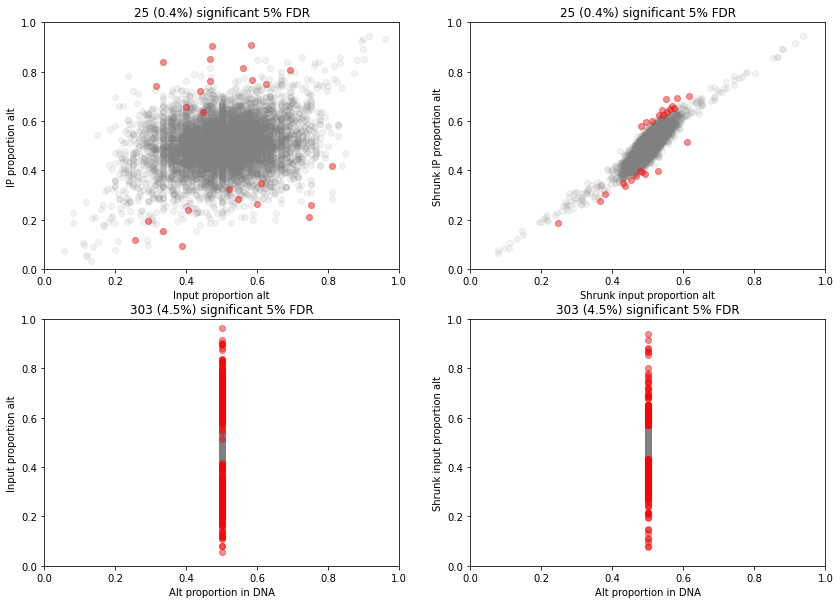

()

In [49]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold, sig_alpha=0.4)